In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


In [3]:
df_name = []
encoding = []
path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    df_name.append(file_name)
    print(f"{file_name}: {result}")

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


In [4]:
data_source = (tuple(df_name), tuple(encoding), tuple(path))

In [5]:
context = pd.read_csv(data_source[2][0], encoding=data_source[1][0])
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
2844,3931,Work,Alo!&ne,Su?n%ny,6 AM,1,1,1,0,1,15,0
8045,15464,Travel,Alone,S%un%ny,8:00,1,0,0,0,1,2,0
2538,18849,Travel,Fa!mily,Su&nny,8:00,1,0,0,0,1,0,0
5393,12885,Travel,Alon e,S?u?nny,9 AM,1,1,0,0,1,0,0
2839,15037,Visit,Alo&?ne,&Su~nny,4PM,1,0,0,0,1,0,0


In [6]:
mobile_plan_attr = pd.read_csv(
    data_source[2][1], encoding=data_source[1][1], delimiter=";"
)

mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
1,DATAGOLD,"5GB/ day, high speed",200000,5d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
0,DATASILVER,"2GB/ day, high speed",100000,5d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d


In [7]:
mobile_plan_user = pd.read_csv(data_source[2][2], encoding=data_source[1][2])
mobile_plan_user.sample(5)

,id,mobile_plan,accept
14544,13391.0,SOCIALMEDIA,0.0
24571,2629.0,DATASILVER,0.0
28544,8084.0,DATACALL,0.0
19458,17910.0,DATACALL,0.0
32163,16470.0,DATACALL,0.0


In [8]:
user = pd.read_csv(data_source[2][3], encoding=data_source[1][3])
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
5742,9237,Пахомов Пахом Бориславович,Male,21,NaN,Student,218100$,S in gle_0,RUSSIA,+7 834 821 05 27,Биоинженер,0,2,3,1,1
3354,12758,Pamela Doyle,Female,35,Masters,Computer & Mathematical,1630000000 VND,Ma r ried_2,US,(846)920-7847,Multimedia programmer,0,7,6,1,0
9321,5834,Rebecca Le,Female,43,Bachelor,Personal Care & Service,368300$,Mar ried_2,US,503-369-2721x74108,"Engineer, production",2,1,1,1,2
2146,8966,Robert Scott,Other,27,Bachelor,Computer & Mathematical,925000000 VND,Marri ed_1,US,(875)217-5508,Copy,1,3,2,2,3
4985,19273,木村 翔太,Male,32,Bachelor,Sales & Related,17500$,Un married_0,JAPAN,13-6578-8641,小説家,0,1,3,3,0


In [9]:
dataset = [context, mobile_plan_attr, mobile_plan_user, user]

# Cleaning

## Missing values check


In [10]:
for x in dataset:
  print('-----------------')
  print(x.isna().sum())

-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64


In [11]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

## Duplicate


In [12]:
user['id'].duplicated().sum()

0

In [13]:
context['id'].duplicated().sum()

0

In [14]:
mobile_plan_user.sort_values(by='id').head()

,id,mobile_plan,accept
18023,1000.0,SOCIALMEDIA,0.0
18022,1000.0,DATACALL,0.0
18021,1000.0,DATASILVER,0.0
3014,1000.0,DATASILVER,1.0
3087,1001.0,SOCIALMEDIA,1.0


## Context


In [15]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
805,9947,Travel,Fam ily,Sun&ny,6 PM,1,1,0,0,1,0,0
2388,17456,Travel,!Al one,!S?&unny,14:00,1,1,0,0,1,0,0
6800,13073,Travel,Friend(s!),Sunn!y,5 PM,1,0,0,0,1,5,0
2976,11782,Visit,Al~!%one,S!u?~nny,19:00,1,0,0,1,0,0,1
11458,14822,Work,%~~?Alone,%~Ra?iny,7 AM,1,0,0,1,0,10,1


In [16]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()

    print(context[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [17]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)

In [18]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M")

In [19]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

context['hour'] = pd.to_datetime(context['time']).dt.hour
context['time_of_day'] = context['hour'].apply(time_of_day)

# One-hot encoding cho các khoảng thời gian trong ngày
context = pd.get_dummies(context, columns=['time_of_day'])

# Bỏ cột thời gian gốc nếu không cần thiết
context = context.drop(columns=['time', 'hour'])

In [20]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

In [21]:
context.purpose.unique()

array(['travel', 'visit', 'work'], dtype=object)

In [22]:
context["purpose"] = context["purpose"].replace('travel', 'visit')

In [23]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])

In [24]:
context.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
6763,4528,visit,family,sunny,1,1,0,0,0,True,False,False,False
2412,10944,work,alone,sunny,1,0,0,0,1,False,False,True,False
5198,19956,work,alone,sunny,1,0,0,1,0,False,False,True,False
1717,12191,work,alone,sunny,1,0,0,0,1,False,False,True,False
9587,14992,work,alone,rainy,1,1,1,17,0,False,False,True,False


## User


In [25]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
6540,12073,Харитонова Марина Андреевна,Female,30,NaN,Office & Administrative Support,1300000000 VND,Unmarri ed_0,RUSSIA,+7 (472) 215-05-99,Плиточник,1,0,7,5,1
2864,6683,Sr. Rodrigo da Rosa,Male,21,Bachelor,Business & Financial,81700$,Unmarried_0,BRAZIL,+55 41 9278-5424,Artista plástico,2,1,6,3,1
10687,6150,胡瑜,Female,37,NaN,Office & Administrative Support,33800$,D ivorced_2,CHINA,13266840335,质量管理/测试经理(QA/QC经理),0,13,6,7,0
9436,14134,차성진,Male,49,Masters,Management,2202500000 VND,Ma r ried_1,KOREA,031-022-9007,일반 의사,0,1,3,1,2
6806,6124,Pedro Henrique Guerra,Male,29,Bachelor,Computer & Mathematical,1435000000 VND,Si ngle_0,BRAZIL,(071) 0516 2279,Designer de jóia,0,3,2,0,1


In [26]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

In [27]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

In [28]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

In [29]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

In [30]:
user.nation.unique()

array(['australia', 'england', 'korea', 'denmark', 'brazil', 'japan',
       'us', 'china', 'russia'], dtype=object)

In [31]:
user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

In [32]:
user = user.rename(columns={"nation": "continent"})

In [33]:
currency_exchange_rate = 23000

# Function to clean and adjust income values
def clean_income(value):
    if 'VND' in value:
        return int(value.replace('VND', '')) / currency_exchange_rate
    elif '$' in value:
        return int(value.replace('$', ''))
    else:
        return int(value)

# Apply the function to the 'income' column
user['income_1'] = user['income'].apply(clean_income)

In [34]:
user['profession'] = user['profession'].str.lower()

In [35]:
user['profession'] = user['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

In [36]:
user["education"] = user["education"].fillna("unknown")
user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")

In [37]:
user.living_with.unique()

array(['unmarried_2', 'unmarried_1', 'single_0', 'married_1', 'married_2',
       'married_4', 'married_3', 'unmarried_0', 'single_2', 'single_1',
       'single_4', 'single_3', 'divorced_2', 'divorced_1', 'divorced_3',
       'married_0', 'unmarried_4', 'divorced_4', 'widowed_0',
       'unmarried_3', 'widowed_4', 'widowed_1', 'widowed_3', 'widowed_2',
       'divorced_0'], dtype=object)

In [38]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

In [39]:
user['income_level'] = user['income_1'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper')

## mobile_plan_attr


In [40]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration
0,DATASILVER,"2GB/ day, high speed",100000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d


In [41]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()

In [42]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')

In [43]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')

In [44]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [45]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [46]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()

In [47]:
mobile_planes = mobile_plan_user.mobile_plan.unique()

### Mobile plan recommendation


In [48]:
mobile_plan_rec_raw = mobile_plan_user[["id"]]

# Create columns for each item in the mobile_plan_user dataframe
for item in mobile_planes:
    mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
        lambda x: 1 if x == item else np.nan
    )

# Check rows that have duplicated ID
duplicate_rows = mobile_plan_rec_raw[
    mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
]
# Sort by ID
duplicate_rows.sort_values("id")

# Fill missing values of each ID group
# In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
mobile_plan_rec = duplicate_rows.groupby("id").apply(
    lambda x: x.fillna(method="ffill").fillna(method="bfill")
)
mobile_plan_rec = mobile_plan_rec.drop_duplicates()

mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

mobile_plan_rec = mobile_plan_rec.fillna(0)
mobile_plan_rec

,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,1.0,0.0,1.0,1.0,0.0
1,1001.0,0.0,0.0,1.0,1.0,0.0
2,1005.0,0.0,0.0,1.0,1.0,1.0
3,1006.0,0.0,0.0,1.0,1.0,0.0
4,1008.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
10107,19992.0,0.0,1.0,1.0,1.0,0.0
10108,19996.0,0.0,1.0,1.0,1.0,1.0
10109,19997.0,1.0,1.0,0.0,0.0,1.0
10110,19998.0,1.0,1.0,1.0,0.0,0.0


### Mobile plan conversion rate


In [49]:
mobile_plan_accept = mobile_plan_user.pivot_table(
index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
).reset_index()

# Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
for plan in mobile_planes:
  if plan not in mobile_plan_accept.columns:
    mobile_plan_accept[plan] = 0

# Sắp xếp lại các cột theo thứ tự trong mobile_planes
mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [50]:
# Sử dụng pivot_table để tổng hợp dữ liệu
num_rec = mobile_plan_user.pivot_table(
    index="id", columns="mobile_plan", values="mobile_plan", aggfunc="count", fill_value=0
).reset_index()

# Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
for plan in mobile_planes:
    if plan not in num_rec.columns:
        num_rec[plan] = 0

# Sắp xếp lại các cột theo thứ tự trong mobile_planes
num_rec = num_rec[["id"] + list(mobile_planes)]

# Đảm bảo rằng cả hai bảng đều có cùng thứ tự cột
assert list(mobile_plan_accept.columns) == list(num_rec.columns)

# Tạo bảng mobile_plan_cr bằng cách chia mobile_plan_accept cho num_rec
mobile_plan_cr = mobile_plan_accept.copy()

# Tính tỷ lệ chuyển đổi (conversion rate)
for plan in mobile_planes:
    mobile_plan_cr[plan] = mobile_plan_accept[plan] / num_rec[plan]

mobile_plan_cr.fillna(0, inplace=True)

# Hiển thị bảng mobile_plan_cr
mobile_plan_cr

mobile_plan,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,0.5,0.0,0.0,0.0,0.0
1,1001.0,0.0,0.0,0.5,0.0,0.0
2,1002.0,0.0,1.0,0.0,0.0,0.0
3,1004.0,0.0,0.0,0.0,0.0,0.0
4,1005.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
11567,19994.0,0.0,0.0,0.0,0.0,0.0
11568,19996.0,0.0,0.0,0.0,1.0,0.0
11569,19997.0,1.0,0.0,0.0,0.0,0.0
11570,19998.0,0.0,0.0,0.0,0.0,0.0


# Data type check


In [51]:
dataset = [context, mobile_plan_attr, mobile_plan_cr, mobile_plan_rec, user]
for x in dataset:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id                        int64
purpose                  object
go_with                  object
weather                  object
viettel_no_0              int64
viettel_no_1              int64
viettel_no_2              int64
score                     int64
direction                 int64
time_of_day_afternoon      bool
time_of_day_evening        bool
time_of_day_morning        bool
time_of_day_night          bool
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
mobile_plan
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           float64
dtype: object
-------------------------
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           

In [52]:
mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


mobile_plan_cr.id = mobile_plan_cr.id.astype(int)
mobile_plan_cr.datasilver = mobile_plan_cr.datasilver.astype(float)
mobile_plan_cr.socialmediagold = mobile_plan_cr.socialmediagold.astype(float)
mobile_plan_cr.socialmedia = mobile_plan_cr.socialmedia.astype(float)
mobile_plan_cr.datacall = mobile_plan_cr.datacall.astype(float)
mobile_plan_cr.datagold = mobile_plan_cr.datagold.astype(float)


mobile_plan_rec.id = mobile_plan_rec.id.astype(int)
mobile_plan_rec.datasilver = mobile_plan_rec.datasilver.astype(int)
mobile_plan_rec.socialmediagold = mobile_plan_rec.socialmediagold.astype(int)
mobile_plan_rec.socialmedia = mobile_plan_rec.socialmedia.astype(int)
mobile_plan_rec.datacall = mobile_plan_rec.datacall.astype(int)
mobile_plan_rec.datagold = mobile_plan_rec.datagold.astype(int)


user.children = user.children.astype(int)
user.income_1 = user.income_1.astype(int)

## Merge


In [53]:
df = (
  user.merge(context, on="id", how="left")
  .merge(mobile_plan_rec, on="id", how="left", suffixes=("", "_rec"))
  .merge(mobile_plan_cr, on="id", how="left", suffixes=("", "_cr"))
)

df.isna().sum()

id                          0
name                        0
gender                      0
age                         0
education                   0
profession                  0
income                      0
living_with                 0
continent                   0
phone                       0
job                         0
fb_freq                     0
yt_freq                     0
insta_freq                  0
use_less_than_2GB           0
use_2GB_to_4GB              0
income_1                    0
marital_status              0
children                    0
income_level                0
purpose                     0
go_with                     0
weather                     0
viettel_no_0                0
viettel_no_1                0
viettel_no_2                0
score                       0
direction                   0
time_of_day_afternoon       0
time_of_day_evening         0
time_of_day_morning         0
time_of_day_night           0
datasilver               1460
socialmedi

In [54]:
df = df.dropna()

## Outliers


In [55]:
to_drop = ['id', 'name', 'income', 'living_with', 'phone', 'job', 'income_1']

In [56]:
df = df.drop(axis=1, columns=to_drop)

In [57]:
df.columns

Index(['gender', 'age', 'education', 'profession', 'continent', 'fb_freq',
       'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',
       'marital_status', 'children', 'income_level', 'purpose', 'go_with',
       'weather', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score',
       'direction', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning', 'time_of_day_night', 'datasilver',
       'socialmediagold', 'socialmedia', 'datacall', 'datagold',
       'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr',
       'datagold_cr'],
      dtype='object')

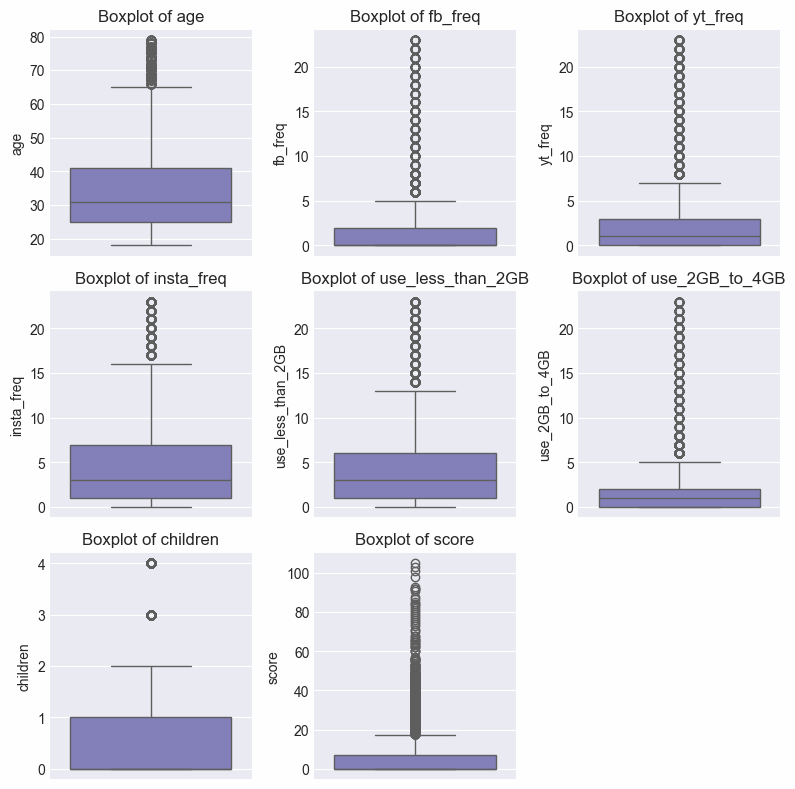

In [58]:
categorical_columns = ['gender', 'education', 'profession', 'income_level', 'continent', 'marital_status', 'purpose', 'go_with', 'weather', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night', 'datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall', 'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr', 'datagold_cr']

continuous_columns = df.drop(axis=1, columns=categorical_columns).columns

# Create a canvas with 4 columns and 4 rows
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Draw boxplot on the canvas
for i, ax in enumerate(axes.flatten()):
    if i < len(continuous_columns):
        sns.boxplot(y=continuous_columns[i], data=df, ax=ax)
        ax.set_title(f'Boxplot of {continuous_columns[i]}')
        ax.set_ylabel(continuous_columns[i])
    else:
        ax.axis('off')

# Fit layout
plt.tight_layout()

plt.show()

In [59]:
# for x in continuous_columns:
#   range = 3
#   Q1 = df[x].quantile(0.25)
#   Q3 = df[x].quantile(0.75)
#   IQR = Q3 - Q1
#   lower_bound = Q1 - range * IQR
#   upper_bound = Q3 + range * IQR

#   df = df[(df[x] >= lower_bound) & (df[x] <= upper_bound)]

#   plt.show()

---


# input

In [60]:
labels = ['datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall']

# EDA

## Univariate


In [61]:
class EDA:
    
    def row(self,data):
        # Display the number of rows and columns in the dataframe
        fig = make_subplots(rows=1, cols=2)
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
        fig.show()
    
    def border_msg(self,msg, indent=1, width=None, title=None):
        """Print message-box with optional title."""
        lines = msg.split('\n')
        space = " " * indent
        if not width:
            width = max(map(len, lines))
        box = f'╔{"═" * (width + indent * 2)}╗\n'  
        if title:
            box += f'║{space}{title:<{width}}{space}║\n'  
            box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  
        box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
        box += f'╚{"═" * (width + indent * 2)}╝' 
        print('\033[92m'+'\033[1m')
        print(box)
        
    def distribution(self,x,title):
        # Plot the distribution of a numerical column
        plt.figure(figsize=(10,8))
        ax = sns.distplot(x, kde=False,bins=30)
        values = np.array([rec.get_height() for rec in ax.patches])
        norm = plt.Normalize(values.min(), values.max())
        colors = plt.cm.jet(norm(values))
        for rec, col in zip(ax.patches,colors):
            rec.set_color(col)
        plt.title(title, size=20, color='black')
        
    def run(self,df):
        
        self.row(df)
        if len(df)>0:
            
            object_df = df.select_dtypes('object').columns.tolist()
            int_df = df.select_dtypes('int').columns.tolist()
            bool_df = df.select_dtypes('bool').columns.tolist()
            float_df = df.select_dtypes('float').columns.tolist()

            if len(object_df)>0:
                
                print( '\033[1m'+"OBJECT TYPE")
                for col in object_df:
                    # Display information about object type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('There are {} unique values in {} column'.format(df[col].nunique(),col.upper()))
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(int_df)>0:
                
                print('\033[1m'+"INT TYPE")
                for col in int_df:
                    # Display information about integer type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('Average value is : {}'.format(df[col].mean()))
                    self.border_msg('Minumum value is : {}'.format(df[col].min()))
                    self.border_msg('Maximum value is : {}'.format(df[col].max()))
                    self.distribution(df[col],title=col)
                    if df[col].mean()>df[col].std():
                        print(self.border_msg("Normal distributed Data Located below mean"))
                        
                    elif df[col].mean()<df[col].std():
                        print(self.border_msg("Normal distributed Data Located above mean"))
                    else:
                        self.border_msg("Mean Equals Std Dev - Distribution is normal")
                        
                    fig = make_subplots(rows=1, cols=2)
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].mean(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "📌 Mean<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].std(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🖇 Standart dev<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
                    fig.show()
                    plt.show()
                 

            if len(bool_df)>0:
                
                print('\033[1m'+"BOOL TYPE")
                for col in bool_df:
                    # Display information about boolean type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(float_df)>0:
                
                print('\033[1m'+"FLOAT TYPE")
                for col in float_df:
                    # Display information about float type columns
                    for col in int_df:
                        self.distribution(df[col],title=col)
                        if df[col].mean()>df[col].std():
                            print(self.border_msg("Normal distributed Data Located below mean"))
                        
                        elif df[col].mean()<df[col].std():
                            print(self.border_msg("Normal distributed Data Located above mean"))
                        else:
                            self.border_msg("Mean Equals Std Dev - Distribution is normal")

In [62]:
# frame = EDA().run(df)

In [63]:
to_check = ['age', 'fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night', 'datasilver', 'socialmediagold', 'socialmedia', 'datacall', 'datagold', 'datasilver_cr', 'socialmediagold_cr','socialmedia_cr', 'datacall_cr', 'datagold_cr']

In [64]:
df.columns

Index(['gender', 'age', 'education', 'profession', 'continent', 'fb_freq',
       'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',
       'marital_status', 'children', 'income_level', 'purpose', 'go_with',
       'weather', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score',
       'direction', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning', 'time_of_day_night', 'datasilver',
       'socialmediagold', 'socialmedia', 'datacall', 'datagold',
       'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr',
       'datagold_cr'],
      dtype='object')

# model

In [65]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score

In [66]:
# Set random seed
seed = 42

# Initialize models
models = {
'Random Forest Classifier': (RandomForestClassifier(random_state=seed)),
'Gradient Boosting Classifier': (GradientBoostingClassifier(random_state=seed)),
'AdaBoost Classifier': (AdaBoostClassifier(random_state=seed)),
'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=seed)),
'SVC': (SVC()),
'KNeighbors Classifier': (KNeighborsClassifier()),
'XGBoost Classifier': (XGBClassifier(tree_method='gpu_hist', random_state=seed))
}

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Prepare to collect results
results = []

# Initialize LabelEncoder dictionary
label_dict = {
  'labels': ['datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall'],
  
  'cr': ['datasilver_cr', 'datagold_cr', 'socialmedia_cr', 'socialmediagold_cr', 'datacall_cr']
}

In [67]:
# Iterate through each label in label_dict['labels']
for i, x in enumerate(label_dict['labels']):
    print(f"Training model for label {x}...")

    current_value = label_dict['cr'][i]
    other = [value for value in label_dict['cr'] if value != current_value]
    features = df.drop(axis=1, columns=label_dict['labels'] + other)

    X = features
    y = df[x]
    
    # Encode categorical columns
    check = (X.dtypes == 'object') | (X.dtypes == 'category')
    object_columns = list(check[check].index)

    if len(object_columns) > 2:
        transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(), object_columns)],
            remainder='passthrough'
        )
        X = transformer.fit_transform(X)
    else:
        label_encoder = LabelEncoder()
        for col in object_columns:
            X[col] = label_encoder.fit_transform(X[col])

    # Initialize variables to store the best model and its metrics
    best_model_name = None
    best_accuracy = 0.0
    best_hamming_loss = 1.0
    best_precision = 0.0
    best_recall = 0.0
    best_f1_score = 0.0

    for name, model in models.items():
        accuracy_cv_scores = []
        hamming_cv_losses = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Train the model using KFold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='micro')
            recall = recall_score(y_test, y_pred, average='micro')
            f1 = f1_score(y_test, y_pred, average='micro')

            accuracy_cv_scores.append(acc)
            hamming_cv_losses.append(hamming)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

        # Calculate the mean of each metric
        mean_accuracy = np.mean(accuracy_cv_scores)
        mean_hamming_loss = np.mean(hamming_cv_losses)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1_score = np.mean(f1_scores)

        # Save the best model and its metrics
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_model_name = name
            best_hamming_loss = mean_hamming_loss
            best_precision = mean_precision
            best_recall = mean_recall
            best_f1_score = mean_f1_score

    # Print the best model and its metrics
    print(f"Best model for label {x}: {best_model_name}")
    print(f"Mean Accuracy: {best_accuracy}")
    print(f"Mean Hamming Loss: {best_hamming_loss}")
    print(f"Mean Precision: {best_precision}")
    print(f"Mean Recall: {best_recall}")
    print(f"Mean F1-score: {best_f1_score}")
    print("*" * 50)

    # Save the results to a list
    results.append({
        'Label': x,
        'Best Model': best_model_name,
        'Mean Accuracy': best_accuracy,
        'Mean Hamming Loss': best_hamming_loss,
        'Mean Precision': best_precision,
        'Mean Recall': best_recall,
        'Mean F1-score': best_f1_score
    })

# Create a DataFrame to store the results
results = pd.DataFrame(results)

Training model for label datasilver...
Best model for label datasilver: SVC
Mean Accuracy: 0.6024516282337686
Mean Hamming Loss: 0.39754837176623137
Mean Precision: 0.6024516282337686
Mean Recall: 0.6024516282337686
Mean F1-score: 0.6024516282337686
**************************************************
Training model for label datagold...
Best model for label datagold: SVC
Mean Accuracy: 0.5642790402947704
Mean Hamming Loss: 0.43572095970522967
Mean Precision: 0.5642790402947704
Mean Recall: 0.5642790402947704
Mean F1-score: 0.5642790402947704
**************************************************
Training model for label socialmedia...
Best model for label socialmedia: Gradient Boosting Classifier
Mean Accuracy: 0.6511066846008783
Mean Hamming Loss: 0.3488933153991218
Mean Precision: 0.6511066846008783
Mean Recall: 0.6511066846008783
Mean F1-score: 0.6511066846008783
**************************************************
Training model for label socialmediagold...
Best model for label socialmedi

In [69]:
results

,Label,Best Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
0,datasilver,SVC,0.602452,0.397548,0.602452,0.602452,0.602452
1,datagold,SVC,0.564279,0.435721,0.564279,0.564279,0.564279
2,socialmedia,Gradient Boosting Classifier,0.651107,0.348893,0.651107,0.651107,0.651107
3,socialmediagold,SVC,0.585641,0.414359,0.585641,0.585641,0.585641
4,datacall,AdaBoost Classifier,0.571002,0.428998,0.571002,0.571002,0.571002
